# Introduction

## Dataset Background

The dataset was created as part of the team project of my 5th Semester of Bachelor studies.
It was used to develop a Sign Language Recognition (SLR) model for a web-based learning application for German Sign Language (DGS).
More information on the project can be found [here](https://sichtraum.hs-augsburg.de/2021/flai).

The dataset was created since most publicly available sign language datasets data at the time contained small sample sizes and were often based on image data.
Models trained on these datasets achieved suspiciously high accuracies and largely didn't seem to generalize to real-world applications.

<img src="./assets/sign-language-mnist.png" width="800"/>

## Data Exploration

The **German Sign Language (DGS) Alphabet** ["contains hand landmark vectors of all static DGS alphabet signs."](https://www.kaggle.com/datasets/moritzkronberger/german-sign-language)

We can download the dataset from Kaggle and see for ourselves what this means:

In [1]:
import kaggle

# Download dataset from Kaggle

# Copy the `kaggle.json` credentials into required directory
# Reference: https://www.kaggle.com/docs/api
! cp kaggle.json ~/.kaggle

kaggle.api.authenticate()
kaggle.api.dataset_download_files('moritzkronberger/german-sign-language', path='./dataset', unzip=True)

The dataset contains 63 coordinates with each sample's label corresponding to a letter in the alphabet.

In [2]:
import pandas as pd

# Load dataset into pandas DataFrame
df = pd.read_csv('./dataset/german_sign_language.csv')
df.head()

,label,coordinate 0,coordinate 1,coordinate 2,coordinate 3,coordinate 4,coordinate 5,coordinate 6,coordinate 7,coordinate 8,...,coordinate 53,coordinate 54,coordinate 55,coordinate 56,coordinate 57,coordinate 58,coordinate 59,coordinate 60,coordinate 61,coordinate 62
0,a,0.699433,0.694308,-5.125001e-07,0.648201,0.623592,-0.013627,0.620721,0.537524,-0.020144,...,-0.021148,0.727923,0.482140,-0.033280,0.721847,0.531752,-0.020166,0.734710,0.541902,-0.006052
1,a,0.287428,0.724731,-7.136206e-07,0.333253,0.645310,-0.004472,0.353996,0.556867,-0.004307,...,-0.014462,0.234728,0.502905,-0.026811,0.247920,0.550634,-0.014552,0.246706,0.571273,-0.000709
2,a,0.617013,0.686834,-6.380658e-07,0.570582,0.624196,-0.011878,0.552030,0.537164,-0.014551,...,-0.017643,0.673824,0.515292,-0.028738,0.659775,0.554122,-0.017304,0.662979,0.563075,-0.005874
3,a,0.300630,0.673777,-6.232622e-07,0.348136,0.606056,-0.007175,0.372517,0.517414,-0.005305,...,-0.009060,0.254527,0.433360,-0.020325,0.264090,0.484955,-0.005042,0.259576,0.507539,0.011589
4,a,0.310373,0.682686,-6.560297e-07,0.355722,0.603330,-0.007532,0.374108,0.519388,-0.008015,...,-0.010770,0.263386,0.461493,-0.023728,0.273920,0.509182,-0.012250,0.264512,0.525097,0.000815


If we examine the unique labels, we can see that ete letters "j" and "z" are missing from the dataset.

This is because in German Sign Language "j" and "z" require motion. Since such dynamic signs would be difficult to recognize from still image (or pose) they were omitted for simplicity.

In [3]:
# List unique labels
labels = df['label'].unique()
labels

array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n',
       'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'],
      dtype=object)

Exploring the usual dataset statistics, we can see that the dataset contains a total of 7306 samples with a mean of 304.417 samples per label.

The letter "p" is features the least amount of times (258 samples) while the letter "l" is featured most often (344 samples).

In [4]:
# Dataset statistics

num_samples = len(df)
num_samples

samples_per_label = df.label.value_counts().sort_index()

mean = samples_per_label.mean()
max_num_l = samples_per_label.max()
min_num_l = samples_per_label.min()
max_l = samples_per_label.idxmax()
min_l = samples_per_label.idxmin()

print(
    f"Total number of samples: {num_samples}\n"
    f"Mean samples per label: {mean}\n"
    f"Min samples per label: {min_num_l} ({min_l})\n"
    f"Max samples per label: {max_num_l} ({max_l})\n"
)

Total number of samples: 7306
Mean samples per label: 304.4166666666667
Min samples per label: 258 (p)
Max samples per label: 344 (l)



Overall, the labels are fairly equally distributed:

<Axes: xlabel='label'>

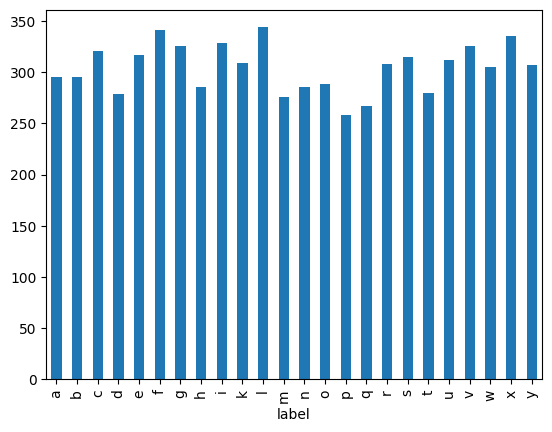

In [5]:
df['label'].value_counts().sort_index().plot(kind='bar')

Now onto the notion of "hand landmarks".

Google's [MediaPipe Handpose Solutions](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker) allows for convenient and robust Handpose Estimation.

Handposes are defined using 21 key points on the hand skeleton, the so called hand landmarks:

<img src="./assets/mediapipe-hand-landmarks.png" width="800"/>

If specified in three dimensions, this will result in 63 coordinates, just like we saw in the dataset.

Finally, let's have a look at the 3D signs featured in the dataset.

The simplest way to do so, would be to simply scatter the coordinates into a 3D plot:

In [6]:
from typing import Literal
import matplotlib.pyplot as plt
import numpy as np

def visualize_3D_hand_landmarks(df, idx):
    # Load linearized coordinates into numpy array
    linearized_coordinates = df.loc[:, df.columns!="label"].to_numpy()

    # Reshape linear coordinates into 3D coordinates
    hand_landmark_coords = linearized_coordinates.reshape((linearized_coordinates.shape[0], -1, 3))

    # Load labels
    labels = df['label']

    # Find global indices of the idx-th labels in data frame
    unique_labels = df['label'].unique()
    viz_indices = []
    for label in unique_labels:
        label_indices = df.index[df['label'] == label].tolist()
        viz_indices.append(label_indices[idx])

    # Determine how many rows and columns will be needed
    num_rows = int(np.sqrt(len(viz_indices)))
    num_columns = int(np.ceil(len(viz_indices) / num_rows))
    aspect_ratio= num_rows / num_columns

    # Create plot
    width = 25
    height = int(width * aspect_ratio)
    fig = plt.figure(figsize=(width, height))

    # Add subplots
    for i in range(len(viz_indices)):
        ax = fig.add_subplot(
            num_rows,
            num_columns,
            i+1,
            projection="3d"
        )
        df_idx = viz_indices[i]
        label = labels[df_idx]
        hand_coords = hand_landmark_coords[df_idx]

        for vec in hand_coords:
            ax.scatter(vec[0], vec[2], vec[1], color='b')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        ax.set_title(f"Sign: {label.upper()}")

    plt.suptitle(f"3D Hand Landmarks")
    plt.show()
    plt.close()

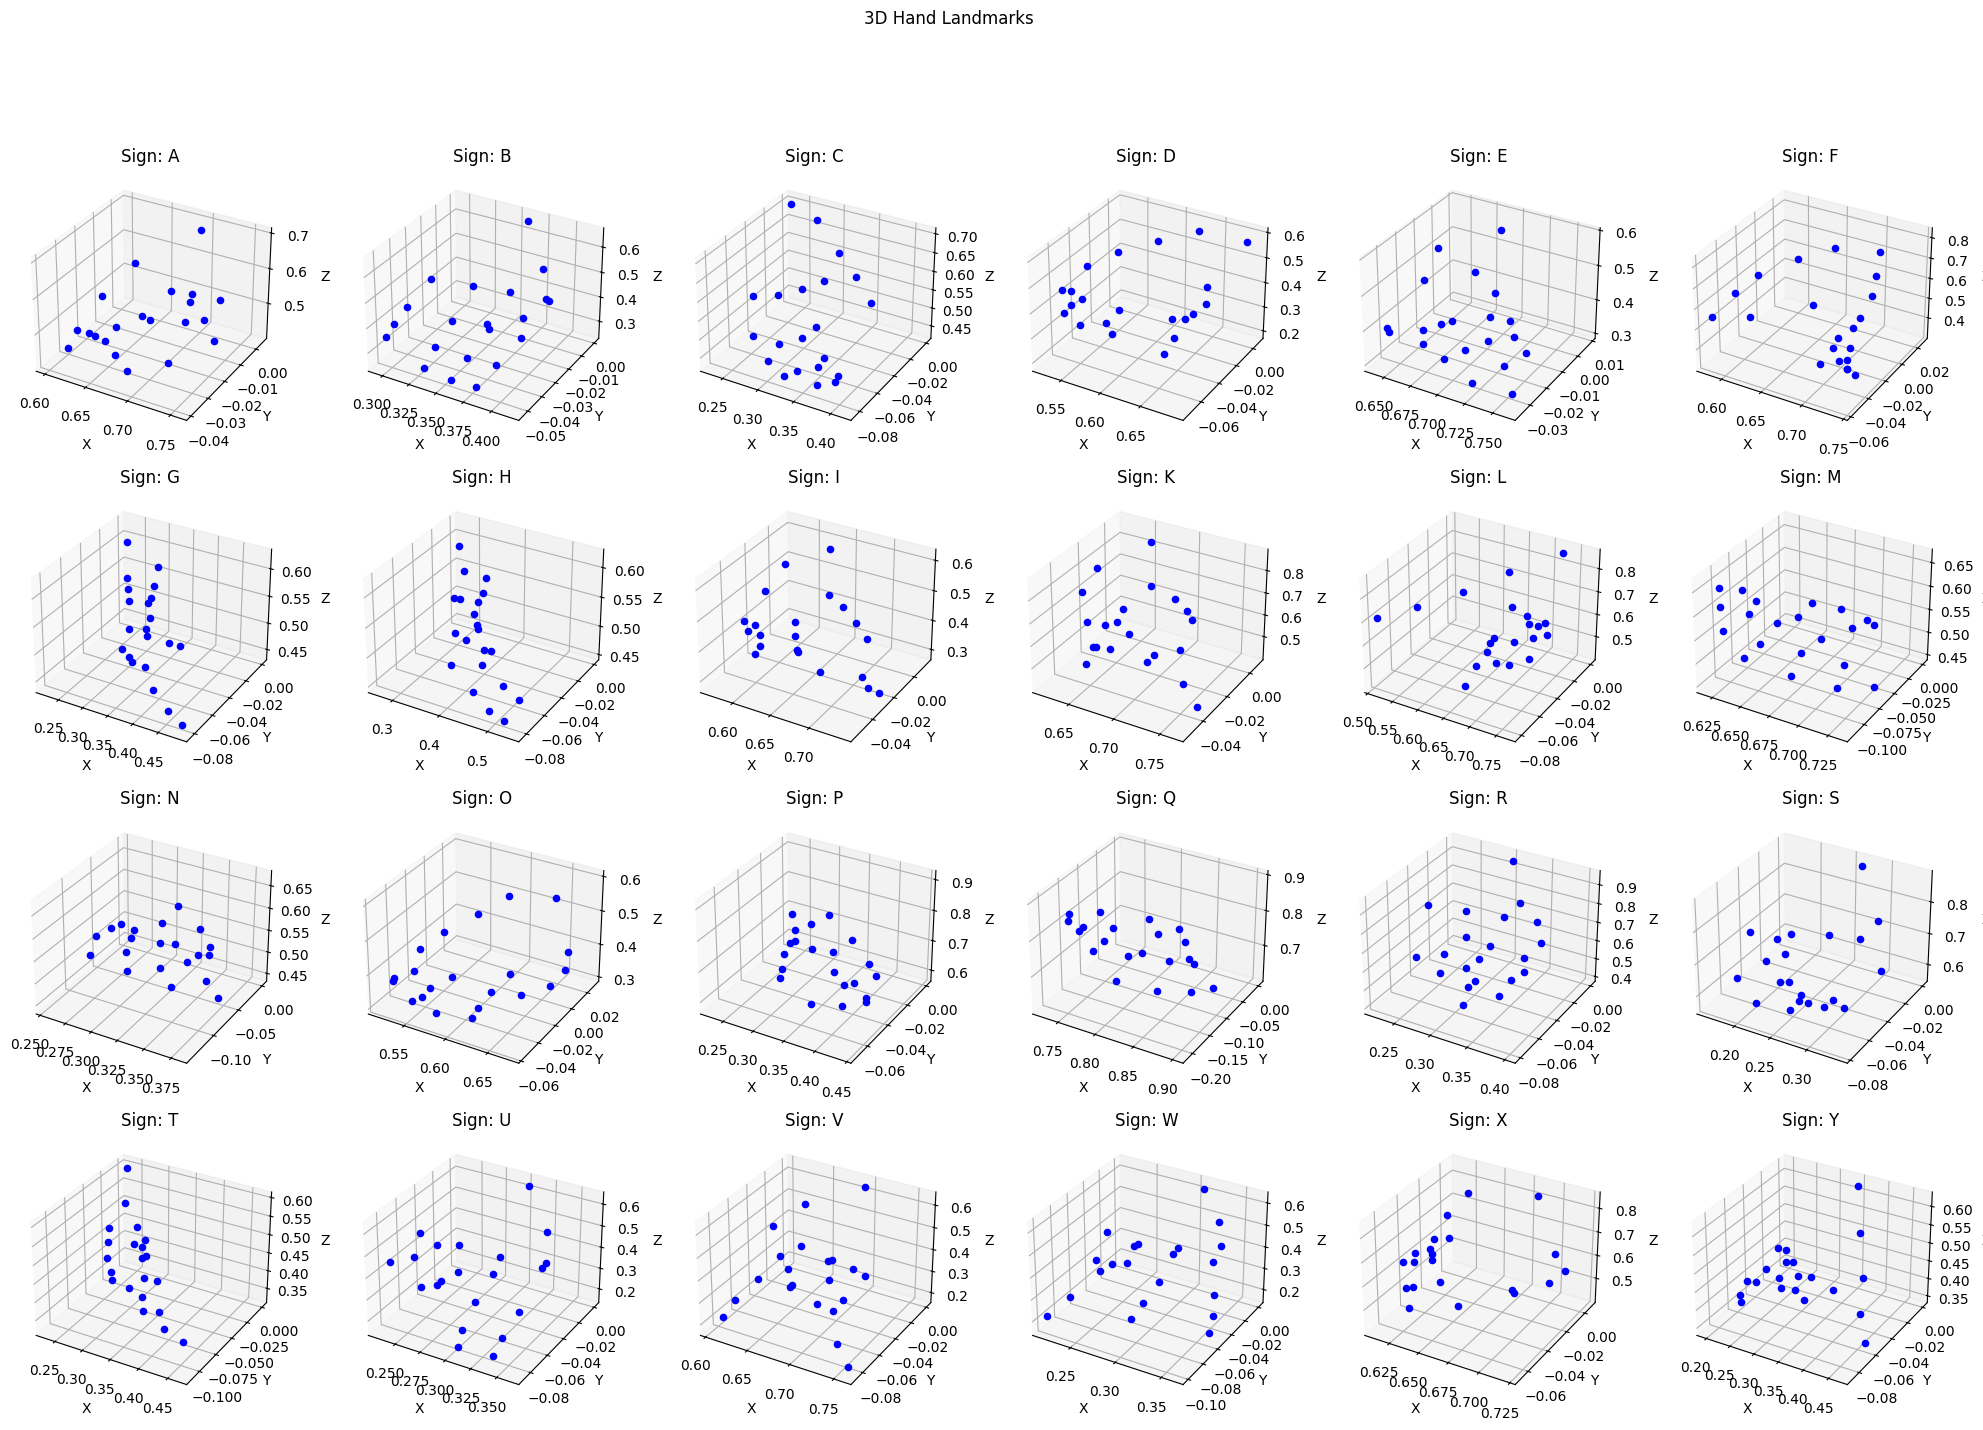

In [7]:
# Visualize signs as 3D points
visualize_3D_hand_landmarks(df, 0)

Unfortunately, this makes it quite hard to tell the structure of the hand, making it difficult to recognize individual signs from German Sign Language:

<img src="./assets/german-sign-language-alphabet.png" width="800"/>

Luckily, "MediaPipe Handpose" offers a way to easily draw the connected hand skeletons from landmark data

We just need to convert our individual coordinates back into the proprietary data format:

In [8]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2


def np_coords_to_landmarks(hand_coords):
    """Convert numpy array containing a hand's landmark coordinates as a numpy array of shape `(21, 3)` into list of MediaPipe `NormalizedLandmarks`."""
    hand_landmarks = [
        landmark_pb2.NormalizedLandmark(x=coord[0], y=coord[1], z=coord[2])
        for coord
        in hand_coords
    ]
    return hand_landmarks


def draw_landmarks(hand_landmarks, height=460, width=460):
    """Draw hand landmarks into empty image.
    
    Adapted from:
    https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb#scrollTo=_JVO3rvPD4RN&line=11&uniqifier=1
    """
    # Create empty image
    image = np.full((height, width, 3), 255, dtype=np.uint8)

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) 
        for landmark
        in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
        image,
        hand_landmarks_proto,
        solutions.hands.HAND_CONNECTIONS,
        solutions.drawing_styles.get_default_hand_landmarks_style(),
        solutions.drawing_styles.get_default_hand_connections_style()
    )

    return image

def visualize_2D_hand_landmarks(df, idx):
    # Load linearized coordinates into numpy array
    linearized_coordinates = df.loc[:, df.columns!="label"].to_numpy()

    # Reshape linear coordinates into 3D coordinates
    hand_landmark_coords = linearized_coordinates.reshape((linearized_coordinates.shape[0], -1, 3))

    # Load labels
    labels = df['label']

    # Find global indices of the idx-th labels in data frame
    unique_labels = df['label'].unique()
    viz_indices = []
    for label in unique_labels:
        label_indices = df.index[df['label'] == label].tolist()
        viz_indices.append(label_indices[idx])

    # Determine how many rows and columns will be needed
    num_rows = int(np.sqrt(len(viz_indices)))
    num_columns = int(np.ceil(len(viz_indices) / num_rows))
    aspect_ratio= num_rows / num_columns

    # Create plot
    width = 25
    height = int(width * aspect_ratio)
    fig = plt.figure(figsize=(width, height))

    # Add subplots
    for i in range(len(viz_indices)):
        ax = fig.add_subplot(
            num_rows,
            num_columns,
            i+1
        )
        df_idx = viz_indices[i]
        label = labels[df_idx]
        hand_coords = hand_landmark_coords[df_idx]

        # Convert to MediaPipe landmarks
        hand_landmarks = np_coords_to_landmarks(hand_coords)
        # Draw landmarks as image
        img = draw_landmarks(hand_landmarks)
        ax.imshow(img)
        ax.axis('off')


        ax.set_title(f"Sign: {label.upper()}")

    plt.suptitle(f"2D Hand Skeletons")
    plt.show()
    plt.close()

With this visualization, spotting the different signs becomes feasible:

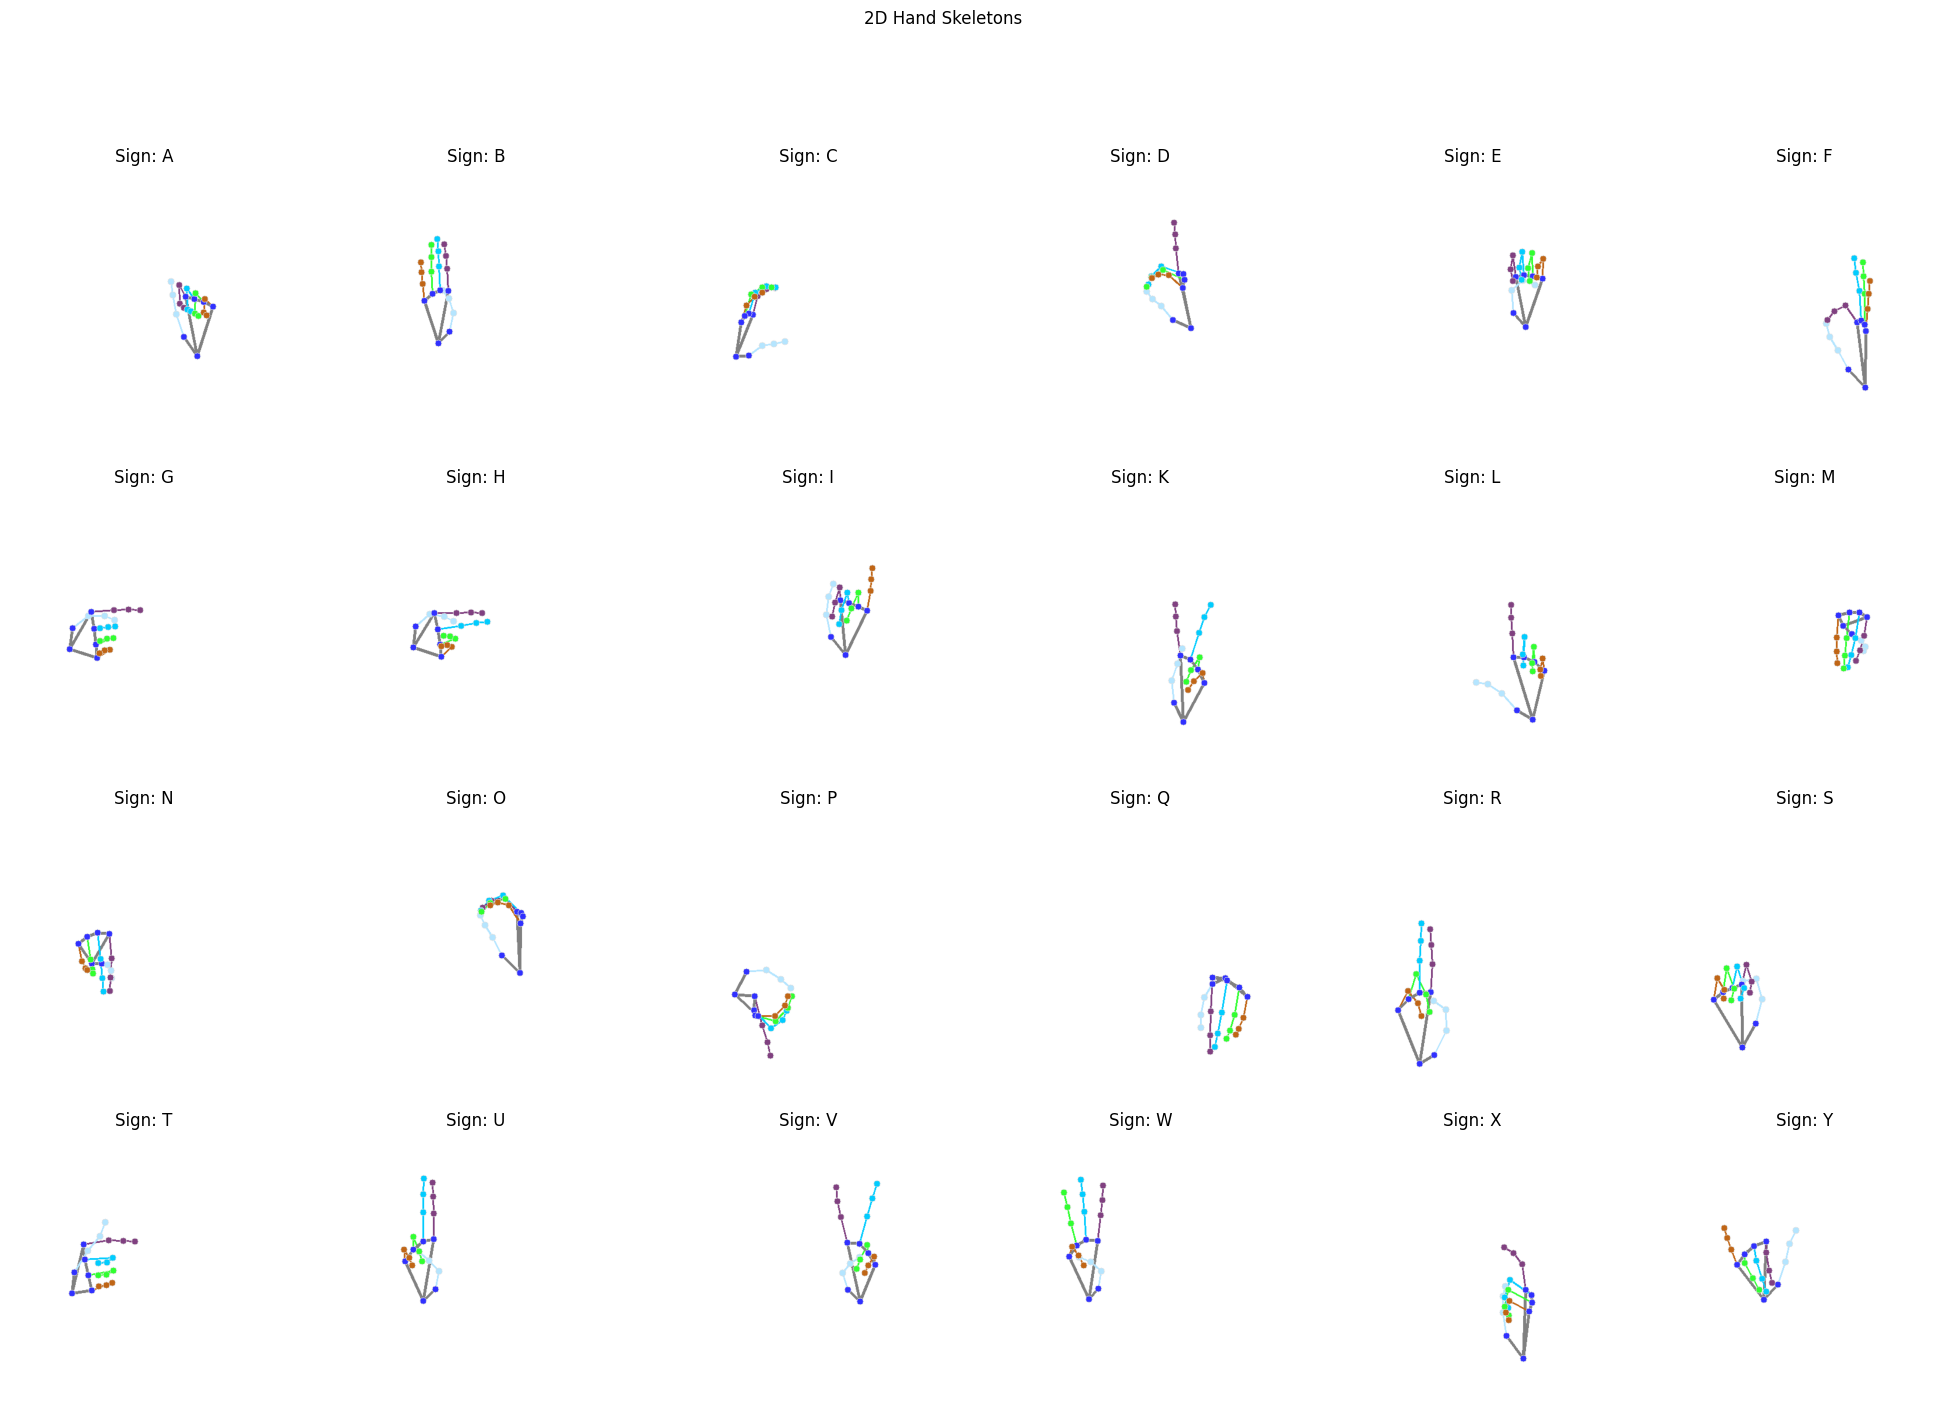

In [9]:
# Visualize alphabet signs as 2D images
visualize_2D_hand_landmarks(df, 0)

## Problems of Sign Language Recognition

Although the Neural Network developed for the task of Sign Language Recognition in the previous project works quite well, the typical approach to such a classification task has a major problem:

What if you want to add new signs to the learning application?

Additional samples for every new sign need to be collected (~300) and the entire model needs to be re-trained.
This is not only labour intensive, but also quite unreliable, maybe our model's performance gets worse with every added class?

Ideally, we would want to train our model once on a limited dataset and have it generalize to all possible future signs.
Maybe the model could compare every sign against a reference and determine if it matches?

This approach is called **One-Shot Learning**.

## Research Question

This project tries to answer the following research question:

**How can popular One-Shot Learning techniques be applied to simple model architectures, that can be used in web-based or mobile sign language learning applications?**

The following notebooks will explore different One-Shot learning methodologies and evaluate them on the "German Sign Language (DGS) Alphabet" dataset.

We will start by exploring the foundation of Contrastive Learning, [the embedding space](./embeddings.ipynb).